Напишем вспомогательные функции для моделирования процесса

In [1]:
import numpy as np
from scipy.stats import distributions, rv_continuous, rv_discrete
from scipy.stats import poisson, uniform
from scipy.misc import derivative
from scipy.integrate import quad
from pynverse import inversefunc
import matplotlib.pyplot as plt
from scipy.stats import norm, geom
from tqdm import trange, tqdm
import mpmath as mp

In [2]:
LAMBDA_1 = 1
U0_1 = 1
C_1 = 7.2
MU = 3.6
LAMBDA_2 = 5
U0_2 = 10
C_2 = 18.9

In [3]:
def gen_my_mix(size, seed=None):
    check = uniform.rvs(size=size, random_state=seed)
    unif = uniform.rvs(loc=1, scale=4, size=size, random_state=seed)
    result = 6 * (check <= 0.2) + unif * (check > 0.2)
    return result

In [4]:
gen_my_mix(20, 1)

array([2.66808802, 3.88129797, 6.        , 2.20933029, 6.        ,
       6.        , 6.        , 2.38224291, 2.5870699 , 3.15526694,
       2.67677806, 3.740878  , 1.817809  , 4.51246975, 6.        ,
       3.68187004, 2.66921921, 3.23475931, 6.        , 6.        ])

In [5]:
def N(t, lamb, seed=None):
    n = poisson.rvs(mu=lamb*t, random_state=seed)
    T = uniform.rvs(scale=t, size=n, random_state=seed)
    return np.sort(T)

In [6]:
def U(t, u0, c, lamb, seed=None):
    sum_upper = N(t, lamb, seed)
    x = gen_my_mix(len(sum_upper), seed=seed)
    time = np.linspace(0, t, t*20)
    time = np.sort(np.concatenate((time, sum_upper)))
    u = u0 + c * time
    ful_sum = np.zeros_like(time)
    for tau, cl in zip(sum_upper, x):
        ful_sum[time >= tau] += cl
    u = u - ful_sum

    return time, u

Сгенерируем траектории:

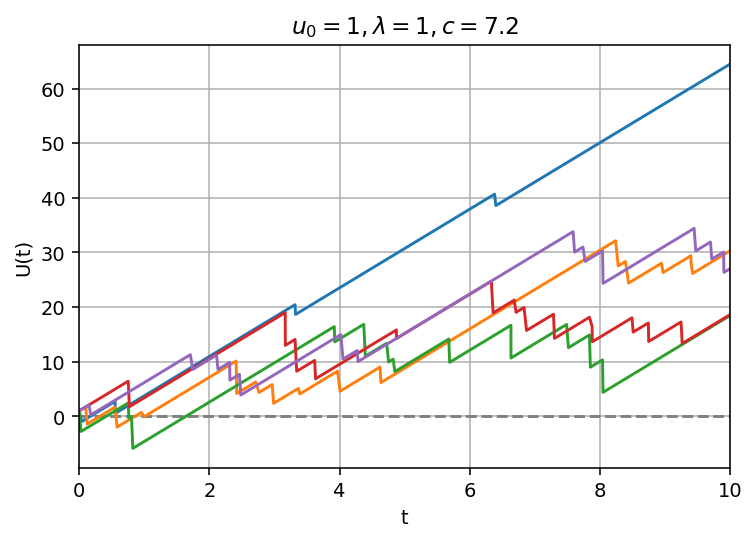

In [7]:
plt.figure(dpi=140)
plt.grid()
plt.xlabel("t")
plt.ylabel("U(t)")
plt.xlim(0, 10)
plt.plot(np.linspace(0, 10, 100), np.zeros_like(np.linspace(0, 10, 100)), linestyle='dashed', color='grey')
#plt.ylim(0, 160)
plt.title("$u_0 = 1, \lambda = 1, c = 7.2$")
for i in range(5):
    time, u = U(10, U0_1, C_1, LAMBDA_1)
    plt.plot(time, u)

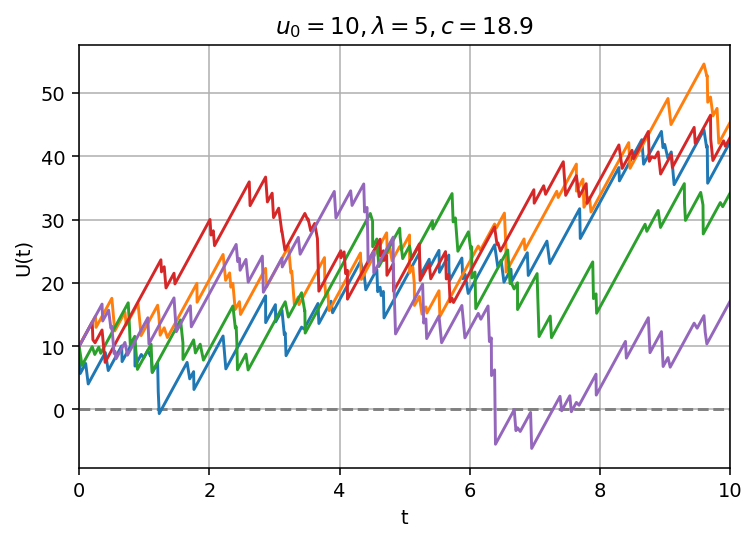

In [8]:
plt.figure(dpi=140)
plt.grid()
plt.xlabel("t")
plt.ylabel("U(t)")
plt.xlim(0, 10)
plt.plot(np.linspace(0, 10, 100), np.zeros_like(np.linspace(0, 10, 100)), linestyle='dashed', color='grey')
plt.title("$u_0 = 10, \lambda = 5, c = 18.9$")
for i in range(5):
    time, u = U(10, U0_2, C_2, LAMBDA_2)
    plt.plot(time, u)

Грубый метод Монте-Карло

In [9]:
bancrupt_1 = 0
for i in trange(1000):
    time, u = U(1000, U0_1, C_1, LAMBDA_1)
    if np.any(u < 0):
        bancrupt_1 += 1
bancrupt_1

100%|██████████| 1000/1000 [00:38<00:00, 25.83it/s]


426

In [10]:
bancrupt_2 = 0
for i in trange(1000):
    time, u = U(1000, U0_2, C_2, LAMBDA_2)
    if np.any(u < 0):
        bancrupt_2 += 1
bancrupt_2

100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]


782

Более точный метод Монте-Карло

In [11]:
def inv_cdf_hat(y):
    if 0 <= y < 10/36:
        return 3.6 * y
    elif 10/36 <= y < 34/36:
        return 6 + np.sqrt(35 - 36*y)
    elif 34/36 <= y <= 1:
        return 18*y - 12

def hat_rvs(size):
    uni = uniform.rvs(size=size)
    return np.array([inv_cdf_hat(i) for i in uni])

In [91]:
# First case
# 1 - (\lambda\mu) / c = 1/2
bancrupt_better_1 = 0
p1 = 1 - (LAMBDA_1*MU) / C_1
for trials_num in tqdm(geom.rvs(p1, loc=-1, size=1000)):
    x_hat = hat_rvs(trials_num)
    if x_hat.sum() > U0_1:
        bancrupt_better_1 += 1
bancrupt_better_1 / 1000

100%|██████████| 1000/1000 [00:00<00:00, 16318.03it/s]


0.434

In [ ]:
# Second case
# 1 - (\lambda\mu) / c = 1 - 18/18.9
bancrupt_better_2 = 0
p2 = 1 - (LAMBDA_2*MU) / C_2
for trials_num in tqdm(geom.rvs(p2, loc=-1, size=1000000)):
    x_hat = hat_rvs(trials_num)
    if x_hat.sum() > U0_2:
        bancrupt_better_2 += 1
bancrupt_better_2 /1000000

  2%|▏         | 20251/1000000 [00:01<01:21, 11967.04it/s]

Обратное преобразование Лапласа

In [17]:
def phi(lmbda, mu, c, p):
    in_denom = 1/p + (0.2 * mp.exp(-6*p) * (-p + mp.exp(p) - mp.exp(5*p)))/(p * p)
    denom = p * (1 - (lmbda/c) * in_denom)
    nom = 1 - (lmbda*mu)/c
    return nom / denom

In [18]:
1 - mp.invertlaplace(lambda p: phi(LAMBDA_1, MU, C_1, p), U0_1, method='dehoog')

mpf('0.42550175952316416')

In [19]:
1 - mp.invertlaplace(lambda p: phi(LAMBDA_2, MU, C_2, p), U0_2, method='dehoog')

mpf('0.77062099879673707')